## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
%matplotlib inline

# Calibrate Camera Function

In [2]:
def camera_calibrate():
    %matplotlib qt
    
    nx = 9
    ny = 6
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            cv2.imshow('img', img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    

    # Test undistortion on an image - calibration 1
    img = cv2.imread('camera_cal/calibration3.jpg')
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('camera_cal/test_undist.jpg',dst)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
    
    # Visualize undistortion
    %matplotlib inline
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    
    return mtx, dist

# Distortion Correction - Get Perspective Matrix

In [3]:
def corners_unwarp(mtx, dist):
    img = cv2.imread('camera_cal/calibration3.jpg')
    nx = 9
    ny = 6    
#     dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
#     mtx = dist_pickle["mtx"]
#     dist = dist_pickle["dist"]
    
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
#     print(ret)
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],\
                          [img_size[0]-offset, img_size[1]-offset],\
                          [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
        
            # vizualize the data
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(warped)
    ax2.set_title('Undistorted and Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return M

# Run Camera Calibrate and Get Perspective Matrix

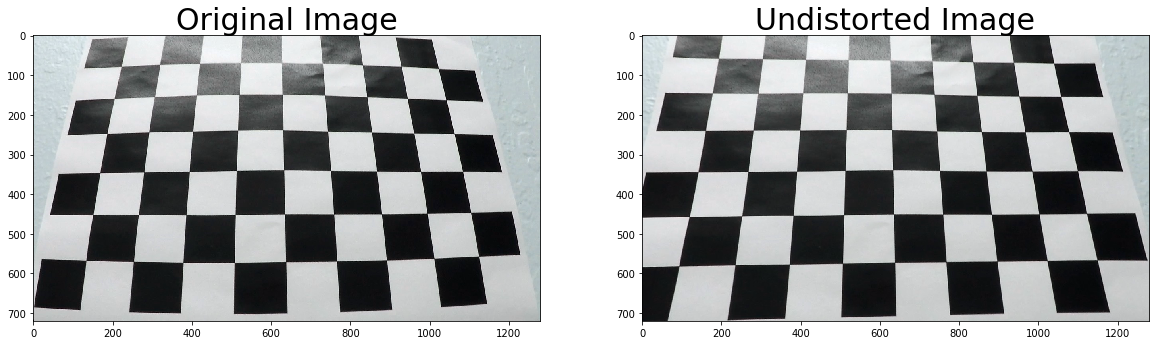

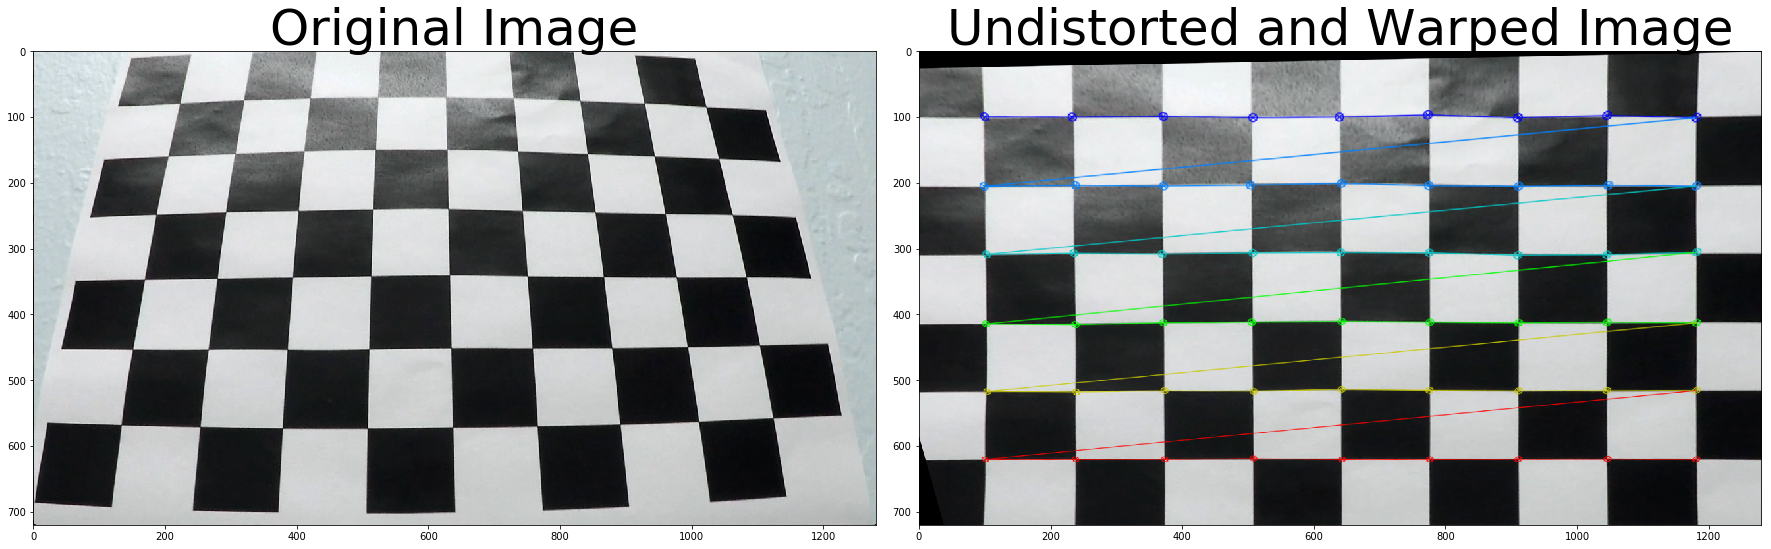

In [4]:
mtx, dist = camera_calibrate()
perspective_M = corners_unwarp(mtx, dist)

# Import Test Images

In [5]:

dirlist = os.listdir("test_images/")
# op_path = "test_images_output"
print(dirlist)

['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


# Individual HSL and Gradient Thresholding Function

In [6]:
def s_select(img, thresh=(100, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
#     binary_output = np.copy(img) # placeholder line
    return binary_output

def l_select(img, thresh=(120, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    l_channel = hls[:,:,1]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
#     binary_output = np.copy(img) # placeholder line
    return binary_output

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img,cv2.CV_64F,1,0))
    else:
        abs_sobel = np.absolute(cv2.Sobel(img,cv2.CV_64F,0,1))
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    sobelx = cv2.Sobel(img,cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img,cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag>=mag_thresh[0]) & (gradmag<=mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    sobelx = cv2.Sobel(img,cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img,cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary
    

# Combined Thresholding Function

In [7]:
def comb_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    
    # img to s threshold
    s_binary = s_select(img,thresh=(150, 255))
    
    # img to l threshold
    l_binary = l_select(img,thresh=(120, 255))   
    
    # schannel to x threshold
    ksize = 9  # Choose a larger odd number to smooth gradient measurements
    gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    
    # combined
    combined = np.zeros_like(s_binary)
    combined[((gradx == 1) | (s_binary == 1)) & ((l_binary == 1) & (s_binary == 1))] = 1

    # apply the region of interest mask
    mask = np.zeros_like(combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(combined, mask)
    
    return thresholded

    

# Perspective View Function

In [8]:
def persp_view(img):
    img_size = (img.shape[1], img.shape[0])
    # Vertices extracted manually for performing a perspective transform
    bottom_left = [200,720]
    bottom_right = [1110, 720]
    top_left = [565, 470]
    top_right = [722, 470]

    source = np.float32([bottom_left,bottom_right,top_right,top_left])

    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    pts = pts.reshape((-1,1,2))
    img_pts = img.copy()
    cv2.polylines(img_pts,[pts],True,(255,0,0), thickness=3)

    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    M = cv2.getPerspectiveTransform(source, dst)
    M_inv = cv2.getPerspectiveTransform(dst, source)
#     img_size = (image_shape[1], image_shape[0])
    
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)
    
    return warped,img_pts,M, M_inv

# Get Threshold Images

In [9]:
for i in dirlist:
    img = mpimg.imread(os.path.join("test_images/",i))
    thresholded = comb_threshold(img)
    undist = cv2.undistort(thresholded, mtx, dist, None, mtx)
    mpimg.imsave(os.path.join("output_images/thresholded/",i),undist)
    warped,img_pts,presp_M,persp_M_inv = persp_view(undist)
    mpimg.imsave(os.path.join("output_images/warped/",i),warped)

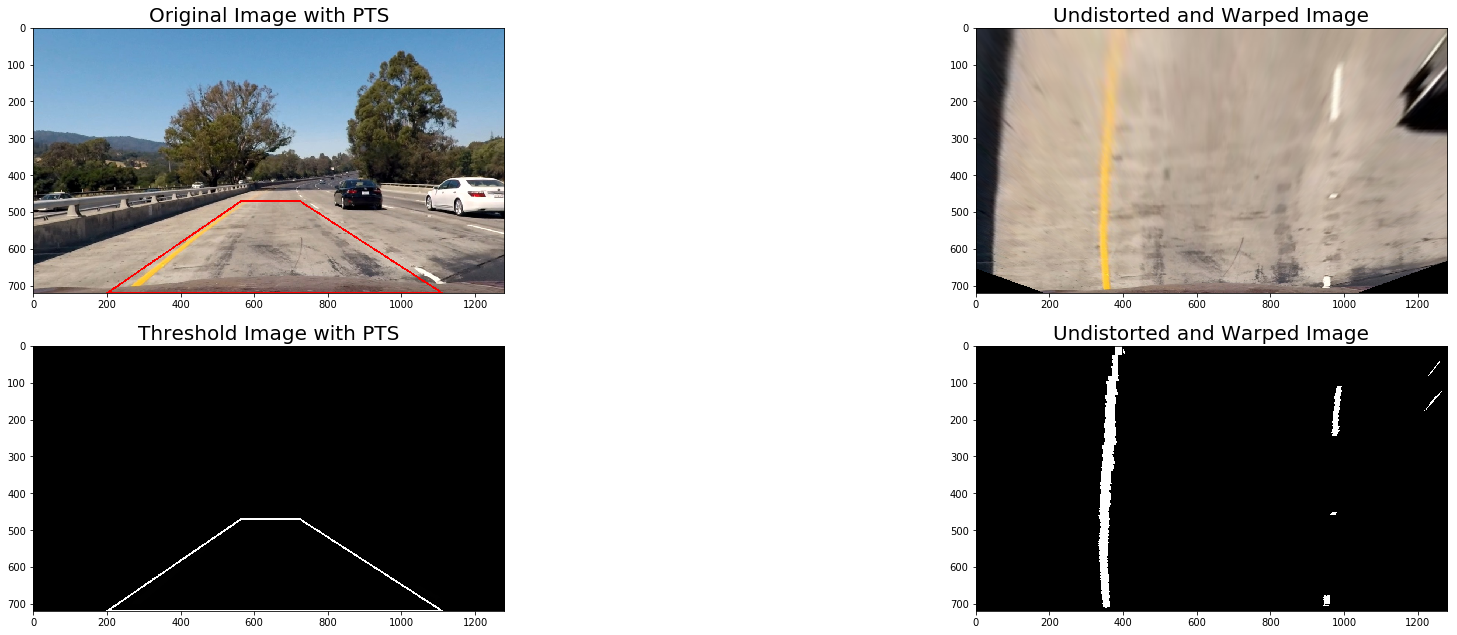

In [10]:

    
img = mpimg.imread('test_images/test1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
warped,img_pts,presp_M,persp_M_inv = persp_view(undist)
thresholded = comb_threshold(img)
undist = cv2.undistort(thresholded, mtx, dist, None, mtx)
thresh_warped,thresh_img_pts,presp_M,persp_M_inv = persp_view(undist)


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
# f.tight_layout()

ax1.imshow(img_pts)
ax1.set_title('Original Image with PTS', fontsize=20)

ax2.imshow(warped, cmap = 'gray')
ax2.set_title('Undistorted and Warped Image', fontsize=20)

ax3.imshow(thresh_img_pts, cmap = 'gray')
ax3.set_title('Threshold Image with PTS', fontsize=20)

ax4.imshow(thresh_warped, cmap = 'gray')
ax4.set_title('Undistorted and Warped Image', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["presp_M"] = presp_M
dist_pickle["persp_M_inv"] = persp_M_inv
pickle.dump( dist_pickle, open( "camera_cal/New_dist_pickle.p", "wb" ) )

# Find Lane Lines and Fit a Polynomial

(720, 1280, 3)


Text(0.5,1,'HISTOGRAM')

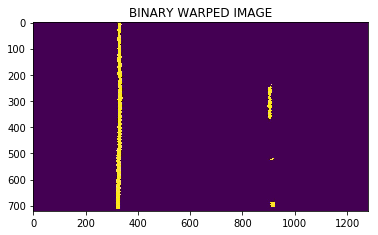

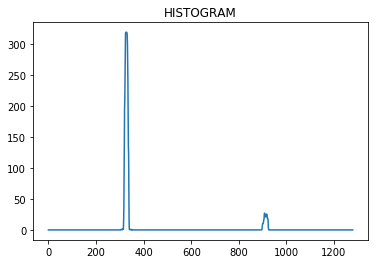

In [11]:

# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread('output_images/warped/straight_lines1.jpg')/255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half,axis=0)
    
    return histogram

# Create histogram of image binary activations

histogram = hist(img[:,:,1])
print(img.shape)

plt.figure(2)
plt.imshow(img)
plt.title('BINARY WARPED IMAGE')
# Visualize the resulting histogram
plt.figure(1)
plt.plot(histogram)
plt.title('HISTOGRAM')
# plt.ylim(0, img.shape[0])
# plt.xlim(0, img.shape[1])



In [12]:
%load_ext autoreload
%autoreload 2
from lane_lines import Lane_Lines

SyntaxError: unexpected EOF while parsing (lane_lines.py, line 185)

In [ ]:
# Load our image
binary_w= mpimg.imread('output_images/warped/straight_lines1.jpg')
img = mpimg.imread('test_images/straight_lines1.jpg')

binary_warped = Lane_Lines(np.copy(binary_w[:,:,1]))
# binary_warped = Lane_Lines(np.copy(binary_w))
out_img = binary_warped.find_lane_pixels()
left_curverad, right_curverad, center_offset_m = binary_warped.measure_curvature_real()
print('Left Lane =' ,"%.2f"% left_curverad, 'm and Right Lane =', "%.2f"% right_curverad, 'm')
radius_string = 'Radius of road = %.2f m'% ((left_curverad+right_curverad)/2)
print(radius_string)
offset_string = 'Center Offset = %.2f m'% center_offset_m
print(offset_string)
plt.imshow(out_img)
plt.title('LANE LINES')

# Unwrap the image

In [ ]:

dstack_thresh = np.dstack((thresh_warped,thresh_warped,thresh_warped))*255
dstack_thresh_size = (dstack_thresh.shape[1], dstack_thresh.shape[0])

left_line_window = np.array(np.transpose(np.vstack([binary_warped.lx, binary_warped.ploty])))

right_line_window = np.array(np.flipud(np.transpose(np.vstack([binary_warped.rx, binary_warped.ploty]))))

line_points = np.vstack((left_line_window, right_line_window))

cv2.fillPoly(dstack_thresh, np.int_([line_points]), [0,255, 0])



un_warped = cv2.warpPerspective(dstack_thresh, persp_M_inv, dstack_thresh_size , flags=cv2.INTER_LINEAR)
plt.figure(1)
plt.imshow(un_warped)
plt.title('UNWARPED LANE')

result = cv2.addWeighted(img, 1, un_warped, 0.3, 0)
cv2.putText(result,radius_string, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
plt.figure(2)
plt.imshow(result)
plt.title('UNWARPED IMAGE WITH LANE')